In [2]:
!pip install torch_geometric

In [3]:
import networkx as nx
import torch
import os
import pandas as pd
from torch_geometric.data import Data
import numpy as np
from dateutil.parser import parse

In [4]:
# process data
# each node is a team (for a year), edges
game_info = pd.read_csv("nfl-game-info.csv")
# team_info = pd.read_csv("team_stats_2003_2023.csv")

teams = pd.concat([game_info['Home Team'], game_info['Away Team']]).unique()
teams = list(teams)
teams.remove('San Diego Chargers')
teams.remove('Washington Redskins')
teams.remove('St. Louis Rams')
teams.remove('Oakland Raiders')
teams.remove('Washington Football Team')
teams = np.array(teams)
print(teams)
team_to_idx = {team: i for i, team in enumerate(teams)}

edge_index = []
edge_attr = []

for _, row in game_info.iterrows():
  date = parse(row["Date"])
  if date < parse('2024-9-5'):
    continue
  # create an edge between two teams,
  team1_idx = team_to_idx[row['Home Team']]
  team2_idx = team_to_idx[row['Away Team']]

  # Add an undirected edge (team1 -> team2 and team2 -> team1)
  edge_index.append([team1_idx, team2_idx])
  edge_index.append([team2_idx, team1_idx])

  edge_attr.append([row["Home Score"], row["Away Score"]])
  edge_attr.append([row["Away Score"], row["Home Score"]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

data = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=len(teams))
print(data)

['Pittsburgh Steelers' 'San Francisco 49ers' 'Denver Broncos'
 'Las Vegas Raiders' 'Washington Commanders' 'Los Angeles Chargers'
 'Seattle Seahawks' 'Cincinnati Bengals' 'Cleveland Browns'
 'Detroit Lions' 'Houston Texans' 'Jacksonville Jaguars' 'Miami Dolphins'
 'New England Patriots' 'Tampa Bay Buccaneers' 'Los Angeles Rams'
 'Arizona Cardinals' 'Atlanta Falcons' 'Buffalo Bills' 'Green Bay Packers'
 'Indianapolis Colts' 'Minnesota Vikings' 'New York Giants'
 'New Orleans Saints' 'New York Jets' 'Carolina Panthers' 'Dallas Cowboys'
 'Baltimore Ravens' 'Philadelphia Eagles' 'Tennessee Titans'
 'Chicago Bears' 'Kansas City Chiefs']
Data(edge_index=[2, 246], edge_attr=[246, 2], num_nodes=32)


In [5]:
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, DataLoader

In [6]:
# Random node features with a fixed dimensionality, e.g., 16
num_nodes = len(teams)
node_feature_dim = 64
node_features = torch.randn((num_nodes, node_feature_dim), dtype=torch.float, )

# Define a GAT model
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8, concat=True)
        self.conv2 = GATConv(hidden_channels * 8, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.elu(x)
        x = self.conv2(x, edge_index)
        return x
    
    def encode(self, x, edge_index):
        return self.forward(x, edge_index)

    def decode(self, z, edge_index):
        # Use dot product to predict if an edge exists
        src, dst = edge_index
        return (z[src] * z[dst]).sum(dim=1)

# Initialize the model
model = GATModel(in_channels=node_feature_dim, hidden_channels=32, out_channels=16)

# Move model and data to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)
node_features = node_features.to(device)

# Get GAT embeddings in a single forward pass
with torch.no_grad():
    embeddings = model(node_features, data.edge_index)

print("GAT Embeddings:")
print(embeddings)

GAT Embeddings:
tensor([[ 8.3189e-02, -2.4680e-01,  1.6084e-01, -1.0790e-01,  3.1718e-01,
         -2.0800e-02,  3.5997e-01,  7.9477e-02, -2.0213e-02, -2.6936e-01,
         -1.9078e-01,  1.4167e-01, -1.4721e-02, -7.1353e-02,  2.2516e-01,
         -2.1900e-01],
        [-4.4408e-02, -3.0886e-01,  7.2289e-02, -2.3993e-01,  5.3333e-03,
          6.9937e-02,  3.2117e-01,  2.1852e-01, -2.0040e-01, -9.6883e-02,
         -2.0572e-01,  6.1515e-02,  3.5699e-02,  3.2782e-02, -1.3735e-02,
         -2.2536e-01],
        [ 1.6741e-01, -2.7040e-01,  1.1550e-01, -2.1313e-01,  2.2181e-01,
         -3.4619e-03,  5.4671e-01,  1.1755e-01,  1.1638e-01, -3.7855e-01,
         -2.4796e-01,  3.1920e-02,  9.5220e-02, -7.4419e-02,  1.3832e-01,
         -8.9736e-02],
        [ 1.4450e-01, -7.6472e-02,  2.1502e-01,  1.0181e-03,  2.2795e-01,
          4.1904e-02,  2.8203e-01,  2.5985e-01,  9.5737e-02, -2.2080e-01,
         -5.4610e-02,  1.3802e-01,  2.1888e-01,  3.7738e-02,  1.5749e-01,
          2.3955e-03],
    

/Users/bradleymoon/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


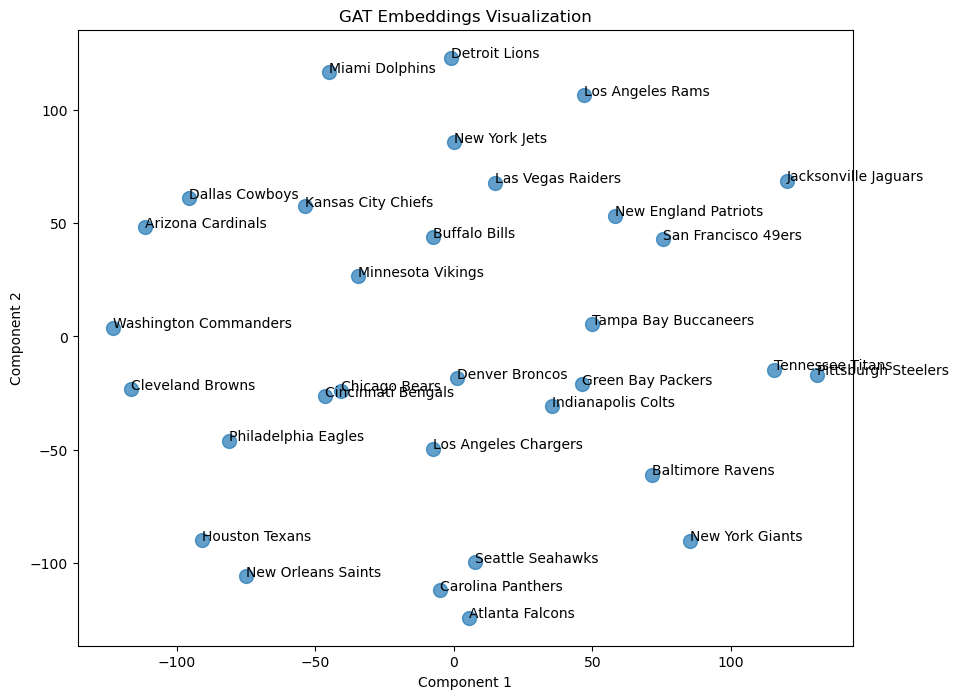

In [7]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming `embeddings` is a tensor of shape [num_nodes, embedding_dim]
embeddings_np = embeddings.cpu().numpy()  # Convert to NumPy for compatibility with sklearn

# Choose either PCA or t-SNE for dimensionality reduction
# Option 1: PCA
# pca = PCA(n_components=2)
# reduced_embeddings = pca.fit_transform(embeddings_np)

# Option 2: t-SNE (for potentially better separation but slower)
tsne = TSNE(n_components=3, random_state=0)
reduced_embeddings = tsne.fit_transform(embeddings_np)

# Plot the reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=100, alpha=0.7)
plt.title("GAT Embeddings Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# Optional: Annotate points with team names or IDs
for i, team in enumerate(teams):
    plt.annotate(team, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.show()


In [8]:
print(len(teams))

32


In [9]:
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling, train_test_split_edges

In [10]:
# Initialize the model
in_channels = node_features.size(1)  # Assuming you use random features as before
hidden_channels = 32
out_channels = 16
model = GATModel(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels).to(device)

# Temporarily remove edge attributes to allow edge splitting
data.edge_attr = None  # Remove edge_attr to use train_test_split_edges

# Perform train/test split on edges
# data = train_test_split_edges(data)

# You can still access `edge_attr` separately if needed
edge_attr = data.edge_attr  # Store edge_attr separately if you need it later


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 10000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # 2. Encode nodes using GAT layers
    z = model.encode(node_features, data.train_pos_edge_index)
    
    # 3. Positive and negative samples for training
    pos_edge_index = data.train_pos_edge_index  # Positive edges from training set
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=z.size(0),
        num_neg_samples=pos_edge_index.size(1)
    )  # Random negative samples
    
    # 4. Decode edges
    pos_pred = model.decode(z, pos_edge_index)
    neg_pred = model.decode(z, neg_edge_index)
    
    # 5. Create labels for positive and negative samples
    pos_label = torch.ones(pos_pred.size(0), device=device)
    neg_label = torch.zeros(neg_pred.size(0), device=device)
    
    # 6. Compute loss (binary cross-entropy)
    loss = F.binary_cross_entropy_with_logits(torch.cat([pos_pred, neg_pred]), torch.cat([pos_label, neg_label]))
    
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Evaluation (link prediction on the test set)
model.eval()
with torch.no_grad():
    z = model.encode(node_features, data.train_pos_edge_index)
    pos_pred = model.decode(z, data.test_pos_edge_index)
    neg_pred = model.decode(z, data.test_neg_edge_index)
    
    pos_label = torch.ones(pos_pred.size(0), device=device)
    neg_label = torch.zeros(neg_pred.size(0), device=device)
    
    # Concatenate predictions and labels for evaluation
    pred = torch.cat([pos_pred, neg_pred])
    label = torch.cat([pos_label, neg_label])
    
    # Use a threshold (e.g., 0.5) on the sigmoid output to classify edges
    pred_class = (torch.sigmoid(pred) > 0.5).float()
    accuracy = (pred_class == label).sum().item() / label.size(0)
    
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

AttributeError: 'GlobalStorage' object has no attribute 'train_pos_edge_index'

GCNEmbeddings (Alternative to GAT)

In [12]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNEmbeddingModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(GCNEmbeddingModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, embedding_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)  # The output of this layer will be the node embeddings
        return x

Node Embeddings:
tensor([[-0.1304, -0.2211,  0.0180, -0.0982, -0.1142, -0.1474, -0.1736,  0.1237,
          0.2415,  0.0093,  0.1964, -0.0342,  0.0884, -0.2358, -0.0442, -0.0013],
        [-0.1280, -0.2257,  0.0215, -0.1081, -0.1116, -0.1736, -0.1929,  0.1064,
          0.2450, -0.0058,  0.1972, -0.0180,  0.0918, -0.2633, -0.0528, -0.0036],
        [-0.1482, -0.2332,  0.0188, -0.1039, -0.1304, -0.1660, -0.1819,  0.1266,
          0.2571, -0.0090,  0.1972, -0.0255,  0.1012, -0.2573, -0.0625,  0.0030],
        [-0.1458, -0.2286,  0.0178, -0.0981, -0.1277, -0.1568, -0.1757,  0.1276,
          0.2511, -0.0057,  0.1933, -0.0275,  0.0979, -0.2466, -0.0593,  0.0018],
        [-0.1294, -0.2121,  0.0189, -0.1050, -0.1161, -0.1651, -0.1745,  0.1046,
          0.2352, -0.0125,  0.1816, -0.0184,  0.0924, -0.2490, -0.0576,  0.0040],
        [-0.1343, -0.2156,  0.0162, -0.0878, -0.1160, -0.1386, -0.1642,  0.1248,
          0.2342,  0.0037,  0.1853, -0.0306,  0.0883, -0.2239, -0.0491, -0.0016],
     

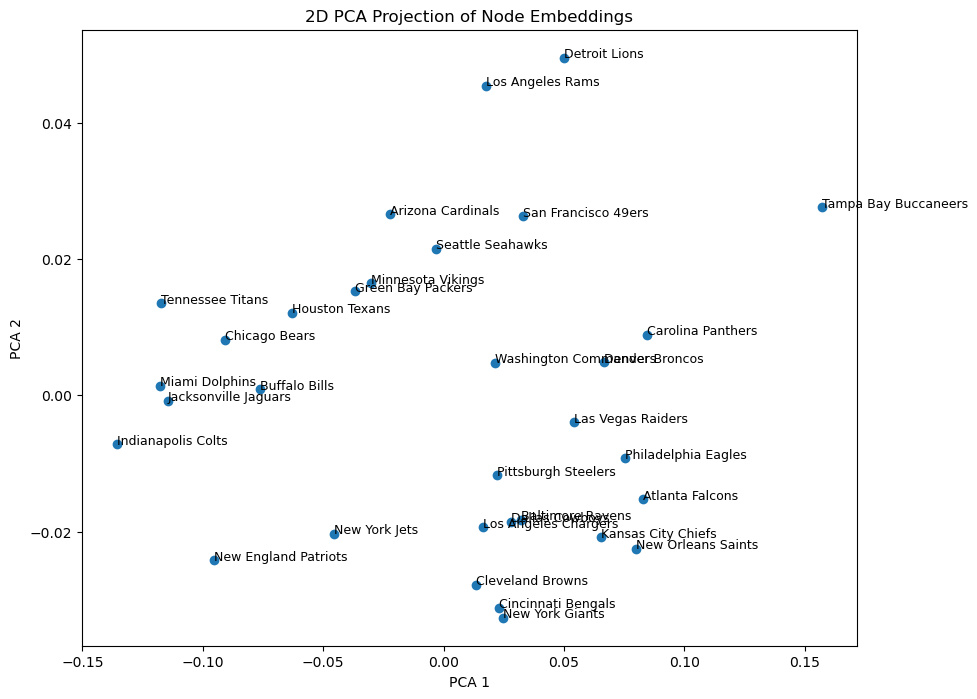

In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the GCN model with embeddings
class GCNEmbeddingModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(GCNEmbeddingModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, embedding_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)  # The output of this layer will be the node embeddings
        return x

# Load data
game_info = pd.read_csv("nfl-game-info.csv")
team_info = pd.read_csv("team_stats_2003_2023.csv")

# Filter games for 2024
game_info_2024 = game_info[game_info['Date'].str.contains("2024")]

# Process teams and create index mapping
teams = pd.concat([game_info_2024['Home Team'], game_info_2024['Away Team']]).unique()
team_to_idx = {team: i for i, team in enumerate(teams)}

# Prepare edge indices and attributes
edge_index = []
edge_attr = []

for _, row in game_info_2024.iterrows():
    team1_idx = team_to_idx[row['Home Team']]
    team2_idx = team_to_idx[row['Away Team']]
    # Add undirected edge with scores as attributes
    edge_index.append([team1_idx, team2_idx])
    edge_index.append([team2_idx, team1_idx])
    edge_attr.append([row["Home Score"], row["Away Score"]])
    edge_attr.append([row["Away Score"], row["Home Score"]])

# Convert to torch tensors and create Data object
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

# Prepare node features
# Placeholder: Each team will have a random feature vector (could be enhanced with real stats)
node_features = torch.rand(len(teams), 4)  # Example: 4 features per node (teams)

data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, num_nodes=len(teams))

# Initialize GCN model
input_dim = node_features.size(1)  # Number of features per node
hidden_dim = 16  # Number of hidden units in GCN layer
embedding_dim = 16  # Dimension of output embeddings

model = GCNEmbeddingModel(input_dim=input_dim, hidden_dim=hidden_dim, embedding_dim=embedding_dim)

# Forward pass to generate node embeddings
node_embeddings = model(data)

# Print out the generated embeddings
print("Node Embeddings:")
print(node_embeddings)

# Example: Visualize embeddings (2D projection using PCA or t-SNE)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(node_embeddings.detach().numpy())

# Plotting the 2D PCA projection of the node embeddings
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1])

# Annotating each point with the team names
print(node_embeddings.shape)
for i, team in enumerate(teams):
    plt.text(node_embeddings_2d[i, 0], node_embeddings_2d[i, 1], team, fontsize=9)

plt.title("2D PCA Projection of Node Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()
